┌ Warning: PlotlyBase 0.8.18 is not compatible with this version of Plots. The declared compatibility is 0.7.
└ @ Plots /Users/Chady/.julia/packages/Plots/nzdhU/src/Plots.jl:28


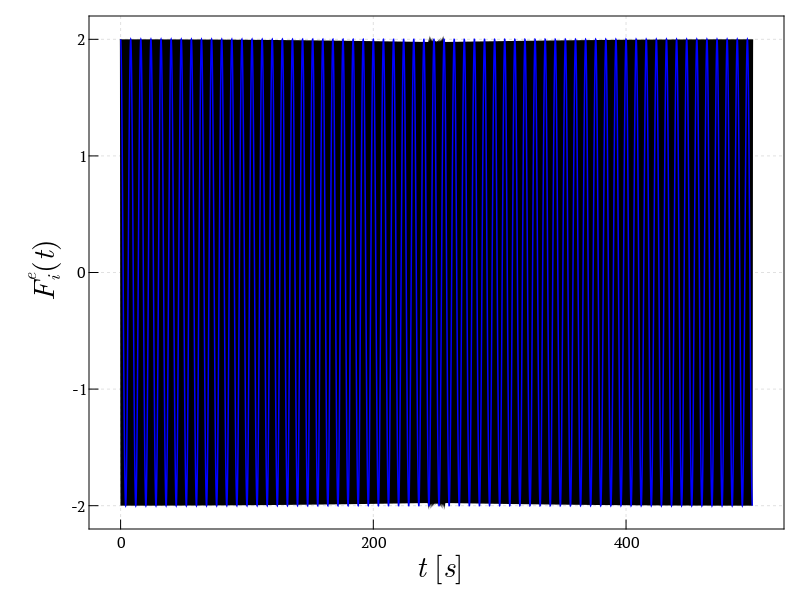

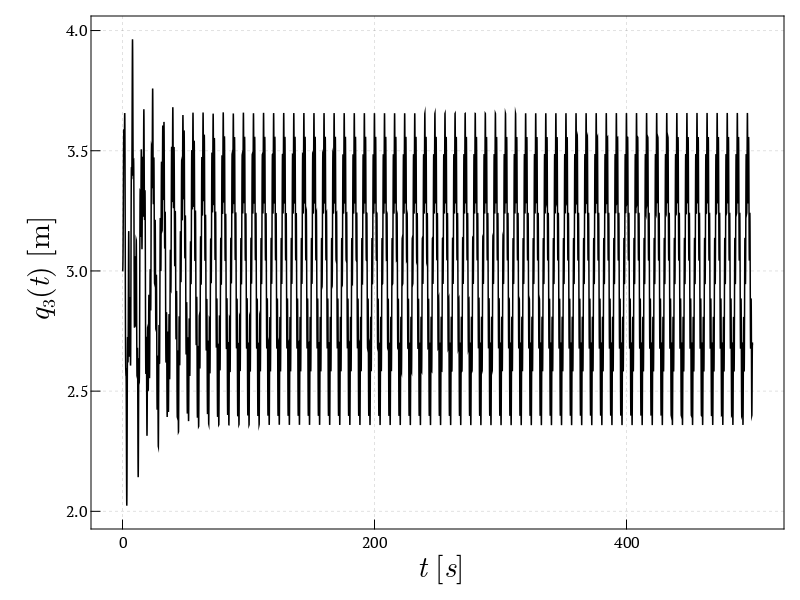

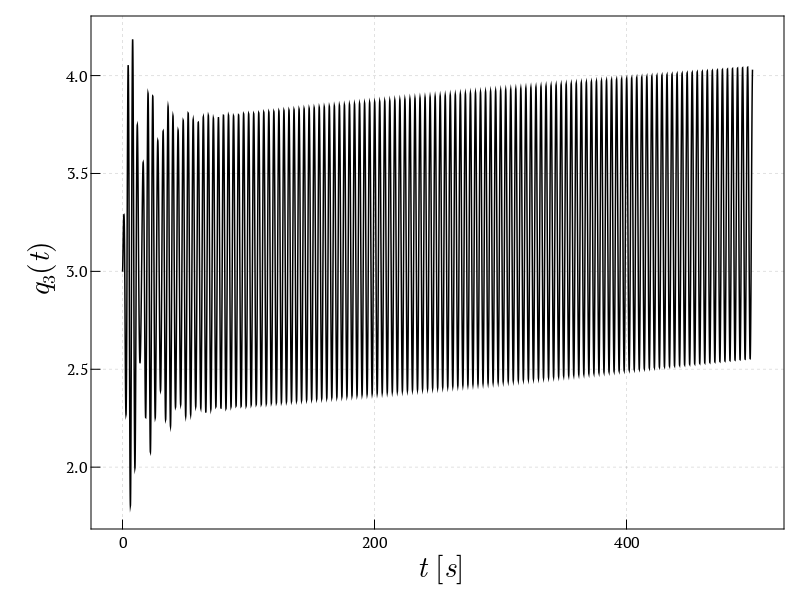

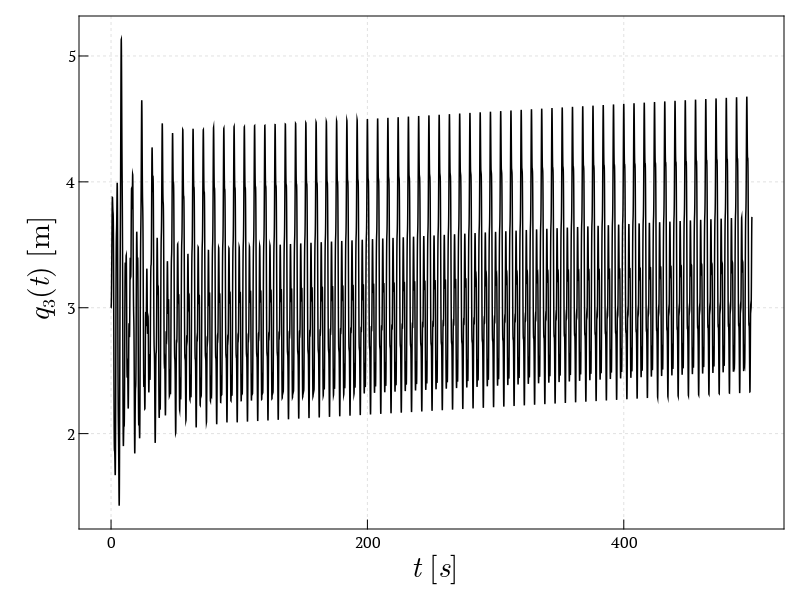

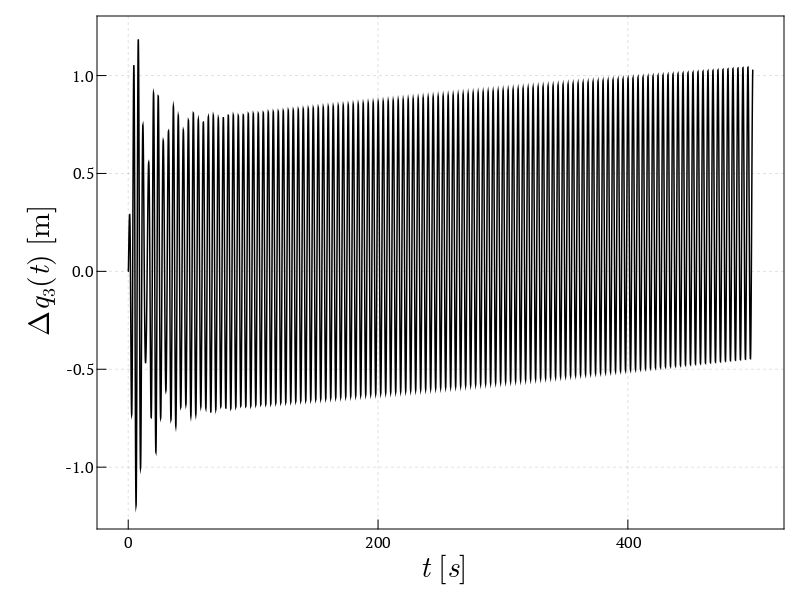

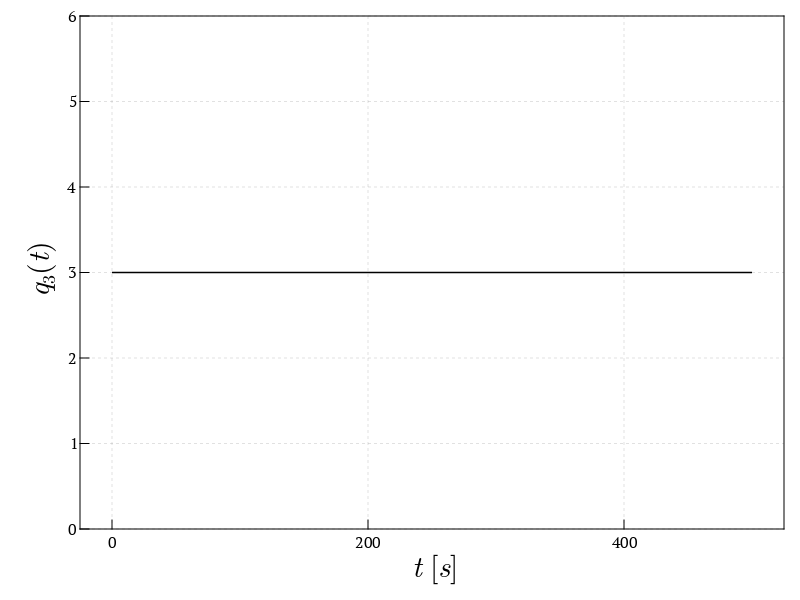

"/Users/Chady/Documents/Research/Codes/Data Kelvin Voight springs/Trois_billes_Case4.csv"

In [1]:
using LaTeXStrings, FFTW, LinearAlgebra, CairoMakie, Peaks, CSV, DataFrames, Flux
import Plots as plt
plt.plotly()

folderPath = @__DIR__

include("utils.jl")

# Plotting parameters
mylinewidth = 1.5
xlabelylabelsizes = 30
mylegendsize = 25
mymarkersize = 9

# Time of simulation and time increment
ttot = 500
Ntime = 10000
tvec = range(0.,ttot,length=Ntime)
Δt = tvec[2] - tvec[1]


# Sampling parameters
Ts = tvec[2] - tvec[1]
ωs = (1/Ts)*2π
Δω = ωs/Ntime
ωvec = collect((0.0:Ntime/2)/Ntime)*ωs

# Defining the model parameters
m1 = 0.5; k1 = 1.0; b1 = 0.8; l1 = 1

k1_0 = 10
k2_0 = 10
k3_0 = 10

alfa = 0.0001

# we create a MassSpringDamper elements
msd1 = MassSpringDamper(m1, k1, b1, l1)

# build the matrix for a system with 3 identical MassSpringDamper elements
T = buildSystemMatrixSeries(msd1, msd1, msd1)
J = buildJterm(msd1, msd1, msd1)
zref = buildZref(msd1, msd1, msd1)


# Defining the perturbation with respect to the initial condition
δz0 = [0., 0., 0., 0., 0., 0.]
z0 = zref + δz0

# Defining Load frequencies 
ωo = π/2 # frequency of the load at the observable Dofs
ωi1 = 2π # frequency of the load at the internal Dofs
ωi2 = π/4 # frequency of the load at the internal Dofs


# Defining the forces functions (5,6 observable)
Fe2(t) = 2*cos(ωi1*t)
Fe4(t) = 2*cos(ωi2*t)
Fe6(t) = cos(ωo*t) + t/ttot
#Fe6(t) = 2

# Defining the force vectors

Fi = zeros(6)
#global Fi = J
Fe = zeros(6)

# Initializing result vectors
q3_F2_F4 = Float32[]
Fe2v = Float32[]
Fe4v = Float32[]


# CASE 1: No load at observable Dof 6
# Simulation with forward Euler
z = z0

k1 = k1_0
k2 = k2_0
k3 = k3_0

for t in tvec
    
    T[2,1] = -(k1+k2)
    T[2,3] = k2
    T[4,1] = T[2,3]
    T[4,3] = -(k2+k3)
    T[4,5] = k3
    T[6,3] = T[4,5]
    T[6,5] = -T[4,5]
    Fi[2] = (k1-k2)*l1
    Fi[4] = (k2-k3)*l1
    Fi[6] = k3*l1

    Fe[2] = Fe2(t)
    Fe[4] = Fe4(t)
    global F = Fi + Fe

    push!(q3_F2_F4, z[5])
    push!(Fe2v, Fe2(t))
    push!(Fe4v, Fe4(t))

    global zdot = T*z + F
    global δz  = zdot*Δt
    global z += δz

    global k1 = k1_0*(1 + alfa*abs(z[1] - l1))
    global k2 = k2_0*(1 + alfa*abs(z[3] - z[1] - l1))
    global k3 = k3_0*(1 + alfa*abs(z[5] - z[3] - l1))


end

# Plots of CASE 1
fig = Figure(font = "CMU Serif") # si se te rompe tienes que instalar CMU serif
    ax = Axis(fig, xlabel = L"t \; [s]", ylabel = L"F_i^e (t)", ylabelsize = xlabelylabelsizes, 
        xlabelsize= xlabelylabelsizes, xgridstyle=:dash, ygridstyle=:dash, xtickalign = 1, 
        xticksize=10, ytickalign=1, yticksize=10,  xlabelpadding = -10)
    lines!(tvec, Fe2v,  linewidth = mylinewidth, color = :black)
    lines!(tvec, Fe4v,  linewidth = mylinewidth, color = :blue)
    fig[1,1] = ax
    display(fig)

fig = Figure(font = "CMU Serif") # si se te rompe tienes que instalar CMU serif
ax = Axis(fig, xlabel = L"t \; [s]", ylabel = L"q_3 (t)\; [\mathrm{m}]", ylabelsize = xlabelylabelsizes, 
    xlabelsize= xlabelylabelsizes, xgridstyle=:dash, ygridstyle=:dash, xtickalign = 1, 
    xticksize=10, ytickalign=1, yticksize=10,  xlabelpadding = -10)
lines!(tvec, q3_F2_F4, linewidth = mylinewidth, color = :black, label = L"q_3")
fig[1,1] = ax
display(fig)
save("q3f2f4.pdf", fig, px_per_unit = 2.0) 

df = DataFrame(time_s = tvec, F2 = Fe2v, F4 = Fe4v, q3=q3_F2_F4)

CSV.write(joinpath(folderPath,"Trois_billes_Case1.csv"),df)



# CASE 2: with load at observable Dof 6 (no load at internal 2, 4)
# Simulation with forward Euler
zdot = zeros(6)
z= zeros(6) 
Fi = zeros(6)
#global Fi = J
Fe = zeros(6)

q3_F6 = Float32[]
Fe6v = Float32[]
z = z0

k1 = k1_0
k2 = k2_0
k3 = k3_0

for t in tvec

    T[2,1] = -(k1+k2)
    T[2,3] = k2
    T[4,1] = T[2,3]
    T[4,3] = -(k2+k3)
    T[4,5] = k3
    T[6,3] = T[4,5]
    T[6,5] = -T[4,5]

    Fi[2] = (k1-k2)*l1
    Fi[4] = (k2-k3)*l1
    Fi[6] = k3*l1

    Fe[6] = Fe6(t)
    global F = Fi + Fe

    push!(q3_F6, z[5])
    push!(Fe6v, Fe6(t))
    global zdot = T*z + F
    global δz  = zdot*Δt
    global z += δz

    global k1 = k1_0*(1 + alfa*abs(z[1] - l1))
    global k2 = k2_0*(1 + alfa*abs(z[3] - z[1] - l1))
    global k3 = k3_0*(1 + alfa*abs(z[5] - z[3] - l1))


end

fig = Figure(font = "CMU Serif") # si se te rompe tienes que instalar CMU serif
ax = Axis(fig, xlabel = L"t \; [s]", ylabel = L"q_3 (t)", ylabelsize = xlabelylabelsizes, 
    xlabelsize= xlabelylabelsizes, xgridstyle=:dash, ygridstyle=:dash, xtickalign = 1, 
    xticksize=10, ytickalign=1, yticksize=10,  xlabelpadding = -10)
lines!(tvec, q3_F6, linewidth = mylinewidth, color = :black, label = L"q_3")
fig[1,1] = ax
display(fig)
save("q3f6.pdf", fig, px_per_unit = 2.0)

df = DataFrame(time_s = tvec, F6 = Fe6v, q3=q3_F6)

CSV.write(joinpath(folderPath,"Trois_billes_Case2.csv"),df)



# CASE 3: with load at observable Dof 6 and load at internal 2 and 4
# Simulation with forward Euler

# Reinitialize to 0
zdot = zeros(6)
z= zeros(6) 
#Fi = zeros(6)
#global Fi = J
Fe = zeros(6)

# Vectors for state var and time
q3_F2_F4_F6 = Float32[]

z = z0

k1 = k1_0
k2 = k2_0
k3 = k3_0

for t in tvec

    T[2,1] = -(k1+k2)
    T[2,3] = k2
    T[4,1] = T[2,3]
    T[4,3] = -(k2+k3)
    T[4,5] = k3
    T[6,3] = T[4,5]
    T[6,5] = -T[4,5]

    Fi[2] = (k1-k2)*l1
    Fi[4] = (k2-k3)*l1
    Fi[6] = k3*l1

    Fe[2] = Fe2(t)
    Fe[4] = Fe4(t)
    Fe[6] = Fe6(t)
    global F = Fi + Fe

    push!(q3_F2_F4_F6, z[5])

    global zdot = T*z + F
    global δz  = zdot*Δt
    global z += δz

    global k1 = k1_0*(1 + alfa*abs(z[1] - l1))
    global k2 = k2_0*(1 + alfa*abs(z[3] - z[1] - l1))
    global k3 = k3_0*(1 + alfa*abs(z[5] - z[3] - l1))

end

fig = Figure(font = "CMU Serif") # si se te rompe tienes que instalar CMU serif
ax = Axis(fig, xlabel = L"t \; [s]", ylabel = L"q_3 (t)\; [\mathrm{m}]", ylabelsize = xlabelylabelsizes, 
    xlabelsize= xlabelylabelsizes, xgridstyle=:dash, ygridstyle=:dash, xtickalign = 1, 
    xticksize=10, ytickalign=1, yticksize=10,  xlabelpadding = -10)
lines!(tvec, q3_F2_F4_F6, linewidth = mylinewidth, color = :black, label = L"q_3")
fig[1,1] = ax
display(fig)
save("q3f2f4f6.pdf", fig, px_per_unit = 2.0) 


fig = Figure(font = "CMU Serif") # si se te rompe tienes que instalar CMU serif
ax = Axis(fig, xlabel = L"t \; [s]", ylabel = L"\Delta q_3 (t)\; [\mathrm{m}]", ylabelsize = xlabelylabelsizes, 
    xlabelsize= xlabelylabelsizes, xgridstyle=:dash, ygridstyle=:dash, xtickalign = 1, 
    xticksize=10, ytickalign=1, yticksize=10,  xlabelpadding = -10)
lines!(tvec, q3_F2_F4_F6 - q3_F2_F4 , linewidth = mylinewidth, color = :black, label = L"q_3")
fig[1,1] = ax
display(fig)
save("deltaq3f2f4f6.pdf", fig, px_per_unit = 2.0) 

df = DataFrame(time_s = tvec, F2 = Fe2v, F4 = Fe4v, F6 = Fe6v, q3=q3_F2_F4_F6)

CSV.write(joinpath(folderPath,"Trois_billes_Case3.csv"),df)


# CASE 4: with no external load applied 

# Reinitialize to 0
zdot = zeros(6)
z= zeros(6) 
Fi = zeros(6)
#global Fi = J
Fe = zeros(6)

# Vectors for state var and time
q3stat = Float32[]

z = z0

k1 = k1_0
k2 = k2_0
k3 = k3_0

for t in tvec

    T[2,1] = -(k1+k2)
    T[2,3] = k2
    T[4,1] = T[2,3]
    T[4,3] = -(k2+k3)
    T[4,5] = k3
    T[6,3] = T[4,5]
    T[6,5] = -T[4,5]

    Fi[2] = (k1-k2)*l1
    Fi[4] = (k2-k3)*l1
    Fi[6] = k3*l1

    global F = Fi + Fe

    push!(q3stat, z[5])

    global zdot = T*z+F
    global δz  = zdot*Δt
    global z += δz

    global k1 = k1_0*(1 + alfa*abs(z[1] - l1))
    global k2 = k2_0*(1 + alfa*abs(z[3] - z[1] - l1))
    global k3 = k3_0*(1 + alfa*abs(z[5] - z[3] - l1))

end

fig = Figure(font = "CMU Serif") # si se te rompe tienes que instalar CMU serif
ax = Axis(fig, xlabel = L"t \; [s]", ylabel = L"q_3 (t)", ylabelsize = xlabelylabelsizes, 
    xlabelsize= xlabelylabelsizes, xgridstyle=:dash, ygridstyle=:dash, xtickalign = 1, 
    xticksize=10, ytickalign=1, yticksize=10,  xlabelpadding = -10)
lines!(tvec, q3stat, linewidth = mylinewidth, color = :black, label = L"q_3")
fig[1,1] = ax
display(fig)
save("q3f0.pdf", fig, px_per_unit = 2.0)

df = DataFrame(time_s = tvec, q3=q3stat)

CSV.write(joinpath(folderPath,"Trois_billes_Case4.csv"),df)